# House Connection Forecast LSTM with Cyclic Input Feed
This experiment tests the many-to-many problem using a LSTM Model. However this time, we do not build the model to a many-to-many configuration. This implies that the it produces only on value for each sequence it gets as an input. However if this input is genrated by the output produced, we can also create an output sequence by running the prediction multiple times. This procedure can be called a cyclic input feed.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
import tensorflow as tf
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential

#### Data Paths
All data paths are collected here for easy adjustments.

In [2]:
input_data_path = r"data/HouseConnection_PxC_2018_2019.csv"

## Load and Prepare and Split Data   

In [3]:
df = pd.read_csv(input_data_path, index_col='ts', parse_dates=['ts'])
df.head()

,kw
ts,
2017-12-31 23:00:00+00:00,NaN
2017-12-31 23:15:00+00:00,21.0
2017-12-31 23:30:00+00:00,20.0
2017-12-31 23:45:00+00:00,21.0
2018-01-01 00:00:00+00:00,21.0


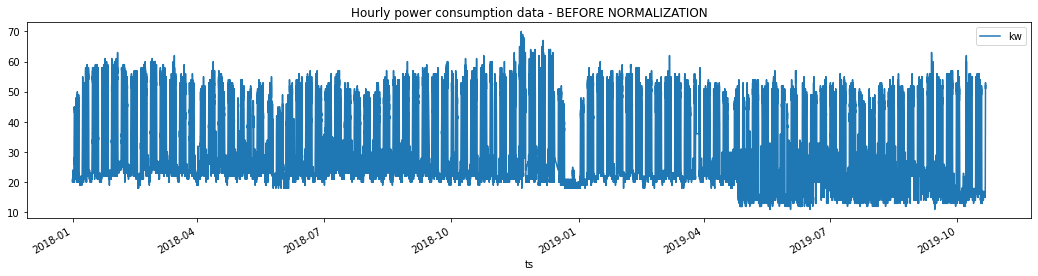

In [4]:
df.plot(figsize=(18, 4),legend=True)
plt.title('Hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [5]:
# Check missing values and drop if data loss is acceptable.
print(df.isna().sum())
df = df.dropna()

kw    1
dtype: int64


For this experiment we focus purely on the consumed kw sequence. That means we forecast future kw consumption based on a historic sequence. Therefore we do not need the weather data which was used in the random forest regressor experiment. We also need to normalize the values as this is usually better for neural networks. The downsampling to an hourly reslution is done to speed up traing.

In [6]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['kw'] = scaler.fit_transform(df['kw'].values.reshape(-1, 1))
    return df

In [7]:
# Normalize the data i.e. bring the values in range [-1, 1].
df_norm = normalize_data(df)
# Sample down the data to hourly resolution in order to reduce parameters.
# Many-to-many configurations tend to produce much more prameters otherwise.
df_norm_h = df_norm.resample('H').mean()
df_norm_h = df_norm_h.reset_index()
df_norm_h = df_norm_h.set_index('ts', drop=True)
df_norm_h.head()

/Users/matthiastitze/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,kw
ts,
2017-12-31 23:00:00+00:00,0.163842
2018-01-01 00:00:00+00:00,0.161017
2018-01-01 01:00:00+00:00,0.165254
2018-01-01 02:00:00+00:00,0.161017
2018-01-01 03:00:00+00:00,0.161017


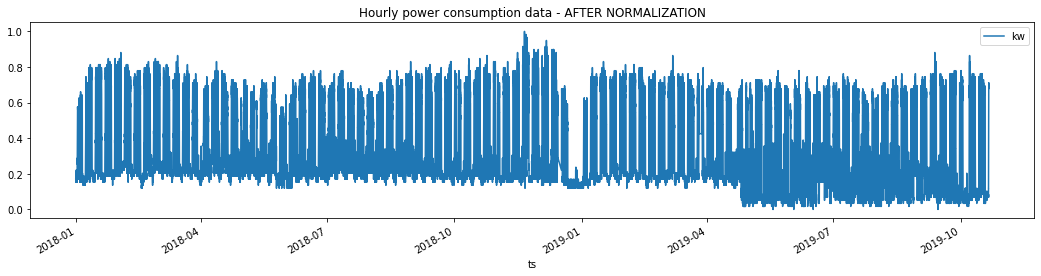

In [8]:
df_norm.plot(figsize=(18, 4),legend=True)
plt.title('Hourly power consumption data - AFTER NORMALIZATION')
plt.show()

#### Prepare data for training the RNN models.

In [9]:
df_norm_h.shape

(15802, 1)

In [10]:
def load_data(stock, seq_len, num_train_samples):
    X = []
    y = []
    
    # Note that the iteration starts at the sequence length.
    # Therefore the data sequence looks as follows:
    # 1. [0 : i-1] => i
    # 2. [1 : i+0] => i+1
    # 3. [2 : i+1] => i+2
    # ...
    # We give a sequence of hour kw as input.
    # The prediction is the kw value for the next hour.
    for i in range(seq_len, len(stock)):
        X.append(stock.iloc[i-seq_len : i, 0])
        y.append(stock.iloc[i, 0])
        
    # We cut of a chunk of data at the start to use for training.
    X_train = X[:num_train_samples]           
    y_train = y[:num_train_samples]
    
    # The rest of the data can be used for testing.
    X_test = X[num_train_samples:]             
    y_test = y[num_train_samples:]
    
    # Convert the dataframes to numpy array.
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Reshape the data to input into RNN models.
    X_train = np.reshape(X_train, (num_train_samples, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [12]:
seq_len = 320
num_train_samples = 12000
X_train, y_train, X_test, y_test = load_data(df_norm_h, seq_len, num_train_samples)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (12000, 320, 1)
y_train.shape =  (12000,)
X_test.shape =  (3482, 320, 1)
y_test.shape =  (3482,)


## Train and Predict using LSTM Model

In [13]:
lstm_model = Sequential()
lstm_model.add(LSTM(40, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation='tanh', return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 320, 40)           6720      
_________________________________________________________________
dropout (Dropout)            (None, 320, 40)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 19,721
Trainable params: 19,721
Non-trainable params: 0
_________________________________________________________________


In [14]:
lstm_model.compile(optimizer='adam', loss='MSE')
lstm_model.fit(X_train, y_train, epochs=4, batch_size=1000)

Epoch 1/4
12/12 [==============================] - 16s 1s/step - loss: 0.0897
Epoch 2/4
12/12 [==============================] - 16s 1s/step - loss: 0.0464
Epoch 3/4
12/12 [==============================] - 16s 1s/step - loss: 0.0413
Epoch 4/4
12/12 [==============================] - 18s 1s/step - loss: 0.0380


In [15]:
X_test.shape

(3482, 320, 1)

In [20]:
future_steps = 320
sequence_length = X_test.shape[1]
# The test data wil be modified on the fly.
X_test_cyclic = []
# We use the first test data sample only - the others will be created.
X_test_cyclic.append(X_test[0:1])
# We need to sore the prediction as the are done in multiple steps.
rnn_predictions = []

In [21]:
def generate_new_input(old_input, next_prediction):
    new_input = old_input.copy()
    
    for i in range(new_input.shape[1] - 1):
        new_input[0][i] = new_input[0][i+1]
        
    new_input[0][current_input.shape[1] - 1] = next_prediction[0]
    return new_input

In [22]:
for i in range(future_steps):
    current_input = X_test_cyclic[i]
    y_pred = lstm_model.predict(current_input)
    rnn_predictions.append(y_pred[0][0])
    X_test_cyclic.append(generate_new_input(current_input, y_pred))

## Evaluate

In [23]:
def plot_predictions(test, predicted, title, start, end):
    plt.figure(figsize=(18, 6))
    plt.plot(test[start:end], color='blue', label='Actual power consumption data')
    plt.plot(predicted[start:end], alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

In [26]:
# Plot interval.
start = 0
end = 320

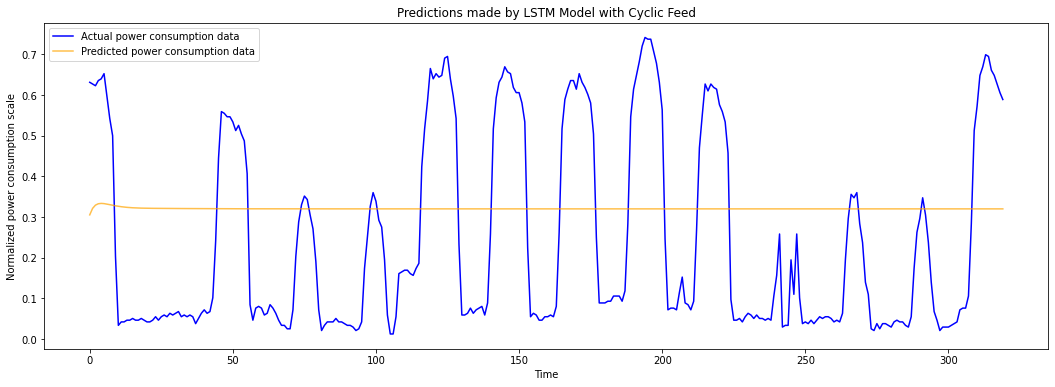

In [29]:
plot_predictions(y_test, rnn_predictions, 'Predictions made by LSTM Model with Cyclic Feed', start, end)